# Imports

In [48]:
import random

import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler



from utils.data_utils_new import scale_data_per_country_new
from utils.model_utils_new import StackedLSTM_new, init_weights

# Get data

In [49]:
def get_pd_from_pkl(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    return df
# df = get_pd_from_pkl(path=r"data\training_data\training_added_feats_no_hospital.pkl")
# df_og = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
# df.head()

df_og = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
df_policies = get_pd_from_pkl(path=r"data\all_policies\policies_individual_final.pkl")
df_vaccines = get_pd_from_pkl(path=r"data\timeseries_pickles\additional_features\better_vaccine_data.pkl")

In [50]:
#MERGE DATAFRAMES

df_vaccines_policies = pd.merge(left=df_vaccines, right=df_policies, how="inner", 
                                on=["location", "date"])
df_vaccines_policies = df_vaccines_policies.sort_values(by=["location", "date"])
df_og = df_og.sort_values(by=["location", "date"])
df_vaccines_policies['new_cases'] = df_og['new_cases']
df = df_vaccines_policies.copy()

In [51]:
info_columns = ['location', 'date']
endog_columns = ['new_cases']
exog_columns = ['c1m', 'c2m', 'c3m', 'c4m', 'c5m', 'c6m', 'c7m',
       'c8ev', 'e1', 'e2', 'h1', 'h2', 'h3', 'h6m', 'h7', 'h8m',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',]
features_to_test = info_columns + endog_columns + exog_columns

In [52]:
full_data = df[features_to_test].dropna().copy()
# full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
#per afegir noves features
# full_data = full_data[features]
full_data.loc[:, 'target'] = full_data['new_cases']

# Filter out locations that appear less than 20 times
location_counts = full_data['location'].value_counts()
valid_locations = location_counts[location_counts >= 20].index
full_data = full_data[full_data['location'].isin(valid_locations)]

In [53]:
random.seed(42)  # Set the random seed for reproducibility
target_country = random.sample(list(full_data.location.unique()), int(full_data.location.nunique()*0.25))
# target_country = ['Spain']

In [54]:
train_data = full_data[~full_data['location'].isin(target_country)].copy()
# test_data = test_data.loc[~test_data['location'].isin(['luxembourg', 'cyprus'])]
test_data = full_data[full_data['location'].isin(target_country)].copy()
# test_data = test_data.loc[~test_data['location'].isin(['luxembourg', 'cyprus'])]

if test_data.empty or test_data.empty:
    raise ValueError("Empty data!")

# Adapt data

In [55]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
from torch.utils.data import Dataset

def create_sequences_new(scaled_data, target_column, endog_columns, policy_columns, seq_length_in, seq_length_out):
    """
    Create encoder input, decoder exog, and decoder target sequences per country
    scaled_data: pd.DataFrame with scaled features + target
    Returns numpy arrays of shapes:
       X_endog: (num_samples, seq_length_in, num_endog)
       X_exog: (num_samples, seq_length_out, num_exog)
       y:      (num_samples, seq_length_out, 1)
    """
    X_endog, X_exog, y = [], [], []
    num_rows = scaled_data.shape[0]
    num_endog = len(endog_columns)
    num_exog = len(policy_columns)

    for i in range(num_rows - seq_length_in - seq_length_out + 1):
        enc_in = scaled_data[endog_columns].iloc[i:i+seq_length_in].values
        dec_ex = scaled_data[policy_columns].iloc[i+seq_length_in:i+seq_length_in+seq_length_out].values
        target_seq = scaled_data[target_column].iloc[i+seq_length_in:i+seq_length_in+seq_length_out].values.reshape(-1, 1)

        X_endog.append(enc_in)
        X_exog.append(dec_ex)
        y.append(target_seq)

    return np.array(X_endog), np.array(X_exog), np.array(y)


def prepare_seq2seq_data_per_country(df, countries, endog_columns, policy_columns, target_column, scaler_class, seq_length_in, seq_length_out):
    X_endog_list, X_exog_list, y_list = [], [], []

    for country in countries:
        country_df = df[df['location'] == country].reset_index(drop=True)

        # Create scalers per country
        scaler_X = scaler_class()
        scaler_y = scaler_class()

        # Scale features & target separately
        features_scaled = scaler_X.fit_transform(country_df[endog_columns + policy_columns])
        target_scaled = scaler_y.fit_transform(country_df[[target_column]])

        # Build scaled DataFrame for easier slicing
        scaled_df = pd.DataFrame(features_scaled, columns=endog_columns + policy_columns)
        scaled_df[target_column] = target_scaled

        # Create sequences per country
        X_endog_c, X_exog_c, y_c = create_sequences_new(
            scaled_df, target_column, endog_columns, policy_columns, seq_length_in, seq_length_out
        )

        X_endog_list.append(X_endog_c)
        X_exog_list.append(X_exog_c)
        y_list.append(y_c)

    # Stack sequences from all countries
    X_endog_all = np.vstack(X_endog_list)
    X_exog_all = np.vstack(X_exog_list)
    y_all = np.vstack(y_list)

    return X_endog_all, X_exog_all, y_all


In [56]:
class Seq2SeqDataset(Dataset):
    def __init__(self, X_endog, X_exog, y):
        self.X_endog = torch.tensor(X_endog, dtype=torch.float32)
        self.X_exog = torch.tensor(X_exog, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_endog[idx], self.X_exog[idx], self.y[idx]


In [ ]:
scaler_class = MinMaxScaler
seq_length_in = 30
seq_length_out = 5
countries_train = list(train_data['location'].unique())
countries_test = list(test_data['location'].unique())
target_column = 'target'


X_endog_train, X_exog_train, y_train = prepare_seq2seq_data_per_country(
    train_data, countries_train, endog_columns, exog_columns, target_column,
    scaler_class, seq_length_in, seq_length_out
)

train_dataset = Seq2SeqDataset(X_endog_train, X_exog_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)


X_endog_test, X_exog_test, y_test = prepare_seq2seq_data_per_country(
    test_data, countries_test, endog_columns, exog_columns, target_column,
    scaler_class, seq_length_in, seq_length_out
)

test_dataset = Seq2SeqDataset(X_endog_test, X_exog_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

# Define the model

In [58]:
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, exog_dim, hidden_dim, num_layers, output_seq_len, dropout=0.0):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_seq_len = output_seq_len

        # Encoder: processes endogenous input sequence
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)

        # Decoder: receives exogenous input for future steps
        self.decoder_lstm = nn.LSTM(exog_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)

        # Final output projection layer
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_input, decoder_exog):
        # encoder_input: [batch, input_seq_len, input_dim]
        # decoder_exog:  [batch, output_seq_len, exog_dim]

        # Encode input sequence
        _, (hidden, cell) = self.encoder_lstm(encoder_input)  # hidden: [num_layers, batch, hidden_dim]

        # Decode future using exogenous inputs
        decoder_output, _ = self.decoder_lstm(decoder_exog, (hidden, cell))  # [batch, output_seq_len, hidden_dim]

        output = self.fc_out(decoder_output)  # [batch, output_seq_len, 1]
        return output


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
input_dim = len(endog_columns)
exog_dim = len(exog_columns)
hidden_dim = 3
num_layers = 1
dropout = 0.5
output_seq_len = seq_length_out  # Same as what you used in your dataset

model = Seq2SeqLSTM(input_dim, exog_dim, hidden_dim, num_layers, output_seq_len, dropout).to(device)


c:\Users\gsamp\Documents\AAAAAAA\TFG\covid_prediction\.venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


# Training

In [61]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.MSELoss()  # or MAE: nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [62]:
num_epochs = 100
print_every = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_endog_batch, X_exog_batch, y_batch in train_loader:
        X_endog_batch = X_endog_batch.to(device)
        X_exog_batch = X_exog_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_endog_batch, X_exog_batch)  # output: [batch, output_seq_len, 1]
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_endog_val, X_exog_val, y_val in test_loader:
            X_endog_val = X_endog_val.to(device)
            X_exog_val = X_exog_val.to(device)
            y_val = y_val.to(device)

            y_pred = model(X_endog_val, X_exog_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch [10/100] - Train Loss: 0.0256, Val Loss: 0.0300
Epoch [20/100] - Train Loss: 0.0186, Val Loss: 0.0233
Epoch [30/100] - Train Loss: 0.0152, Val Loss: 0.0188
Epoch [40/100] - Train Loss: 0.0133, Val Loss: 0.0158
Epoch [50/100] - Train Loss: 0.0125, Val Loss: 0.0145
Epoch [60/100] - Train Loss: 0.0117, Val Loss: 0.0142
Epoch [70/100] - Train Loss: 0.0114, Val Loss: 0.0141
Epoch [80/100] - Train Loss: 0.0111, Val Loss: 0.0137
Epoch [90/100] - Train Loss: 0.0107, Val Loss: 0.0133
Epoch [100/100] - Train Loss: 0.0105, Val Loss: 0.0134


# Validation

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_endog_val, X_exog_val, y_val in test_loader:
        X_endog_val = X_endog_val.to(device)
        X_exog_val = X_exog_val.to(device)
        y_val = y_val.to(device)

        y_pred = model(X_endog_val, X_exog_val)  # shape: [batch, output_seq_len, 1]
        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y_val.cpu().numpy())

# Concatenate batches
all_preds = np.concatenate(all_preds, axis=0)  # shape: [num_samples, output_seq_len, 1]
all_targets = np.concatenate(all_targets, axis=0)

# Flatten to (num_samples * output_seq_len)
all_preds_flat = all_preds.reshape(-1)
all_targets_flat = all_targets.reshape(-1)

mse = mean_squared_error(all_targets_flat, all_preds_flat)
mae = mean_absolute_error(all_targets_flat, all_preds_flat)
r2 = r2_score(all_targets_flat, all_preds_flat)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")


Test MSE: 0.0136
Test MAE: 0.0671
Test R²: 0.5985


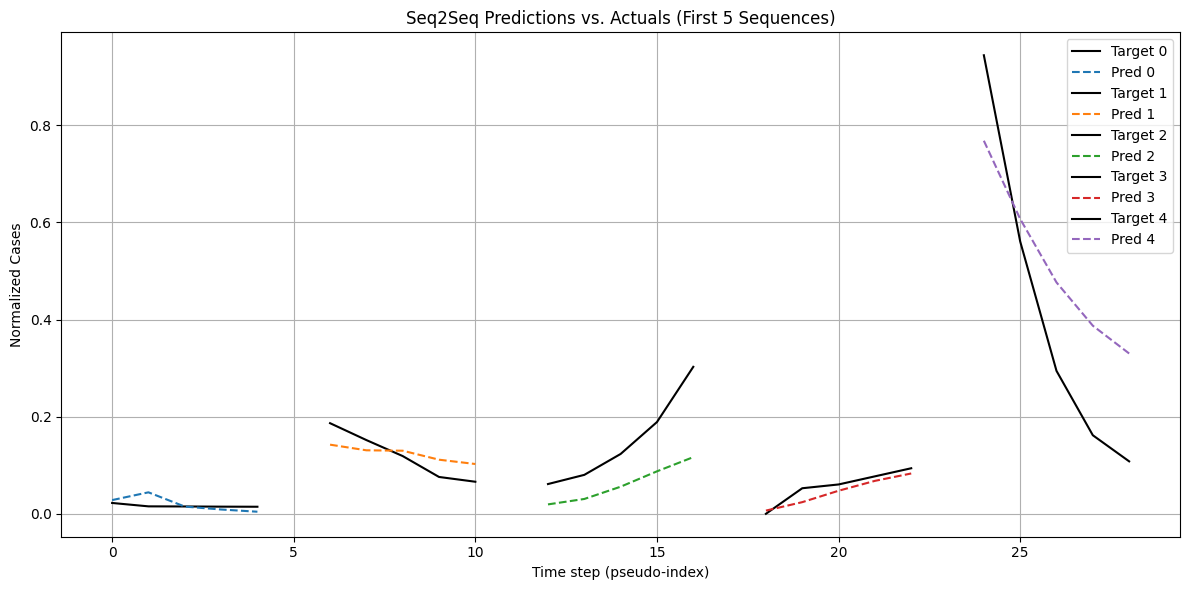

In [66]:
import matplotlib.pyplot as plt

def plot_pred_vs_actual(all_preds, all_targets, num_sequences=5, output_seq_len=5, offset=0):
    """
    Plots a few sequences of predictions vs actuals.

    Args:
        all_preds (np.array): Predicted values, shape [num_samples, output_seq_len, 1]
        all_targets (np.array): Ground truth values, same shape.
        num_sequences (int): Number of sequences to plot.
        output_seq_len (int): Length of each predicted sequence.
        offset (int): Starting index of sequence to plot from.
    """
    plt.figure(figsize=(12, 6))

    for i in range(num_sequences):
        idx = offset + i
        pred = all_preds[idx].flatten()
        target = all_targets[idx].flatten()

        plt.plot(range(i * (output_seq_len + 1), i * (output_seq_len + 1) + output_seq_len), target, label=f'Target {i}', color='black', linestyle='-')
        plt.plot(range(i * (output_seq_len + 1), i * (output_seq_len + 1) + output_seq_len), pred, label=f'Pred {i}', linestyle='--')

    plt.xlabel('Time step (pseudo-index)')
    plt.ylabel('Normalized Cases')
    plt.title(f'Seq2Seq Predictions vs. Actuals (First {num_sequences} Sequences)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual(all_preds, all_targets, num_sequences=5, output_seq_len=5)



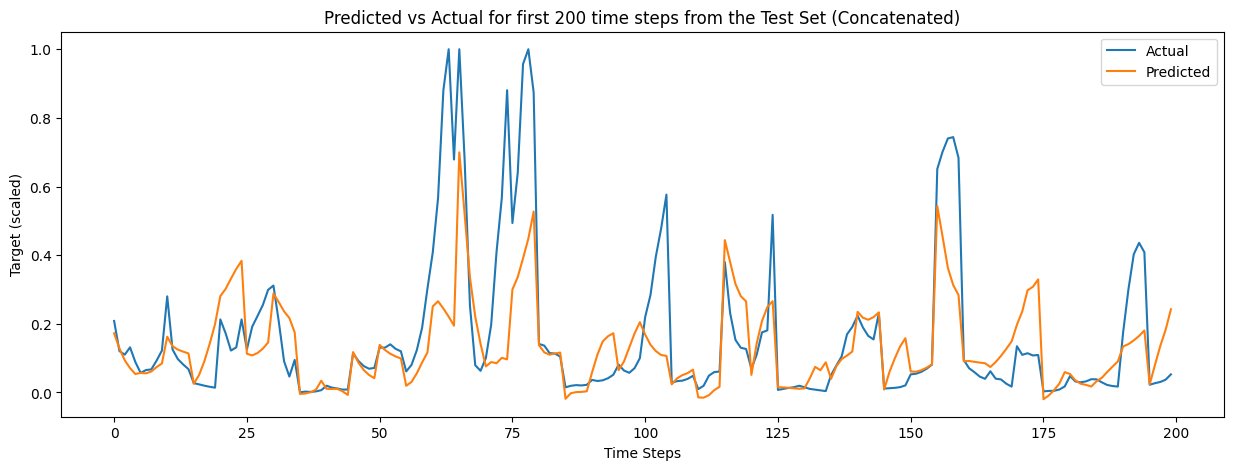

In [104]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_endog_val, X_exog_val, y_val in test_loader:
        X_endog_val = X_endog_val.to(device)
        X_exog_val = X_exog_val.to(device)
        y_val = y_val.to(device)

        y_pred = model(X_endog_val, X_exog_val)  # shape: [batch, output_seq_len, 1]
        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y_val.cpu().numpy())

# Concatenate all batches along batch dimension
all_preds = np.concatenate(all_preds, axis=0)  # shape: (num_samples, output_seq_len, 1)
all_targets = np.concatenate(all_targets, axis=0)

# Flatten into 1D arrays by concatenating all output sequences end to end
predicted_full = all_preds.reshape(-1)
actual_full = all_targets.reshape(-1)

# Optionally inverse scale if you want original scale
# predicted_full = scaler_y.inverse_transform(predicted_full.reshape(-1, 1)).flatten()
# actual_full = scaler_y.inverse_transform(actual_full.reshape(-1, 1)).flatten()

plt.figure(figsize=(15,5))
plt.plot(actual_full[:200], label="Actual")
plt.plot(predicted_full[:200], label="Predicted")
plt.title("Predicted vs Actual for first 200 time steps from the Test Set (Concatenated)")
plt.xlabel("Time Steps")
plt.ylabel("Target (scaled)")
plt.legend()
plt.show()


# Simulations

In [70]:
def simulate_next_days(model, last_30_days_endog, next_7_days_exog, device='cpu'):
    """
    Uses a trained Seq2Seq model to forecast the next 7 days.

    Args:
        model: Trained Seq2SeqLSTM model
        last_30_days_endog (Tensor): [1, 30, num_endog_features]
        next_7_days_exog (Tensor): [1, 7, num_exog_features]
        device (str): Device to run the model on

    Returns:
        Tensor: [1, 7, 1] predicted values
    """
    model.eval()
    last_30_days_endog = last_30_days_endog.to(device)
    next_7_days_exog = next_7_days_exog.to(device)

    with torch.no_grad():
        y_pred = model(last_30_days_endog, next_7_days_exog)  # [1, 7, 1]
    
    return y_pred.cpu()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

random.seed(0)
simulate_country = random.choice(target_country)
simulate_country = random.choice([x for x in full_data['location'].unique() if x != simulate_country])
simulate_data = full_data.loc[full_data['location'] == simulate_country].copy()
random_index = random.randint(5, len(simulate_data) - 50)
random_index = 100
data_index_end = random_index + seq_length_in

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

endog_data_in = simulate_data[endog_columns][random_index: data_index_end].values
endog_data_out = simulate_data[endog_columns][data_index_end: data_index_end + seq_length_out].values

exog_data_in = simulate_data[exog_columns][random_index:data_index_end].values
exog_data_out = simulate_data[exog_columns][data_index_end:data_index_end + seq_length_out].values

last_30_days_endog = torch.tensor(scaler_X.fit_transform(endog_data_in), dtype=torch.float32)
next_7_days_exog = torch.tensor(scaler_X.fit_transform(exog_data_out), dtype=torch.float32)

# Run simulation
predicted_7_days = simulate_next_days(model, last_30_days_endog, next_7_days_exog, device)

In [102]:
from sklearn.preprocessing import MinMaxScaler

random.seed(0)
simulate_country = random.choice(target_country)
simulate_country = random.choice([x for x in full_data['location'].unique() if x != simulate_country])
simulate_data = full_data.loc[full_data['location'] == simulate_country].copy()
random_index = random.randint(5, len(simulate_data) - 50)
random_index = 100
data_index_end = random_index + seq_length_in

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

endog_data_in = simulate_data[endog_columns][random_index: data_index_end].values
endog_data_out = simulate_data[endog_columns][data_index_end: data_index_end + seq_length_out].values

exog_data_in = simulate_data[exog_columns][random_index:data_index_end].values
exog_data_out = simulate_data[exog_columns][data_index_end:data_index_end + seq_length_out].values

last_30_days_endog = torch.tensor(scaler_X.fit_transform(endog_data_in), dtype=torch.float32)
next_7_days_exog = torch.tensor(scaler_X.fit_transform(exog_data_out), dtype=torch.float32)

# Run simulation
predicted_7_days = simulate_next_days(model, last_30_days_endog, next_7_days_exog, device)

In [107]:
from sklearn.preprocessing import MinMaxScaler

random.seed(0)
simulate_country = random.choice(target_country)
simulate_country = random.choice([x for x in full_data['location'].unique() if x != simulate_country])
simulate_data = full_data.loc[full_data['location'] == simulate_country].copy()
random_index = random.randint(5, len(simulate_data) - 50)
random_index = 120

all_preds = []
for random_index in range(30, len(simulate_data) - seq_length_in, 5):
    data_index_end = random_index + seq_length_in

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    endog_data_in = simulate_data[endog_columns][random_index: data_index_end].values
    endog_data_out = simulate_data[endog_columns][data_index_end: data_index_end + seq_length_out].values

    exog_data_in = simulate_data[exog_columns][random_index:data_index_end].values
    exog_data_out = simulate_data[exog_columns][data_index_end:data_index_end + seq_length_out].values

    last_30_days_endog = torch.tensor(scaler_X.fit_transform(endog_data_in), dtype=torch.float32)
    next_7_days_exog = torch.tensor(scaler_X.fit_transform(exog_data_out), dtype=torch.float32)

    # Run simulation
    predicted_7_days = simulate_next_days(model, last_30_days_endog, next_7_days_exog, device)
    all_preds.append(predicted_7_days.cpu().numpy())
all_preds = np.concatenate(all_preds, axis=0)  # shape: (num_samples, output_seq_len, 1)


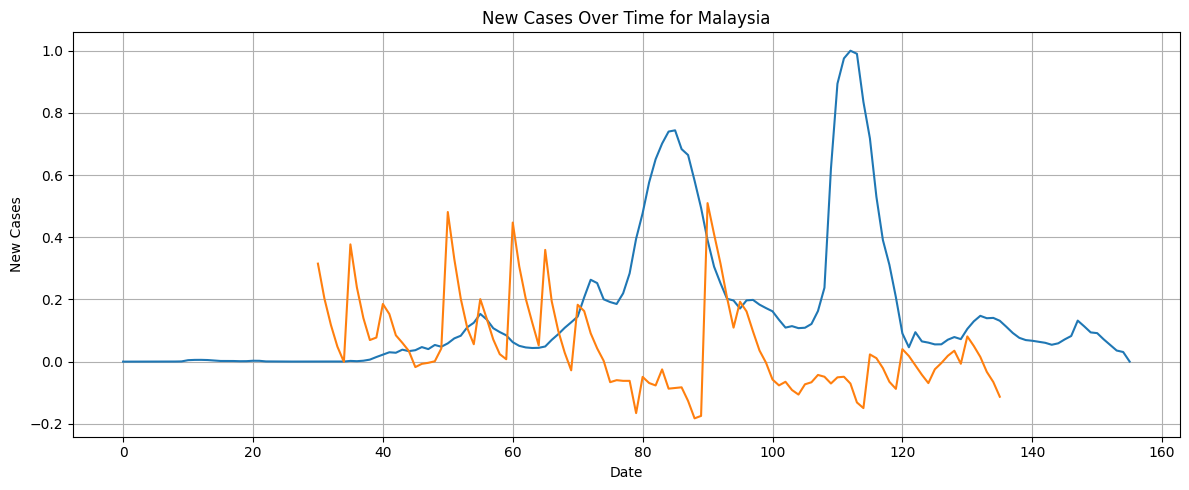

In [109]:
import matplotlib.pyplot as plt
length_data = len(simulate_data)
x_pred = np.arange(30, len(simulate_data) - seq_length_in)
plt.figure(figsize=(12, 5))
# plt.axvline(x=random_index, color='red', linestyle='--', label=f'Index {random_index}')
plt.plot(simulate_data.reset_index().index, scaler_y.fit_transform(simulate_data[['new_cases']].values))
plt.plot(x_pred, all_preds, label='Prediction (next 5 days)')
plt.title(f"New Cases Over Time for {simulate_country}")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

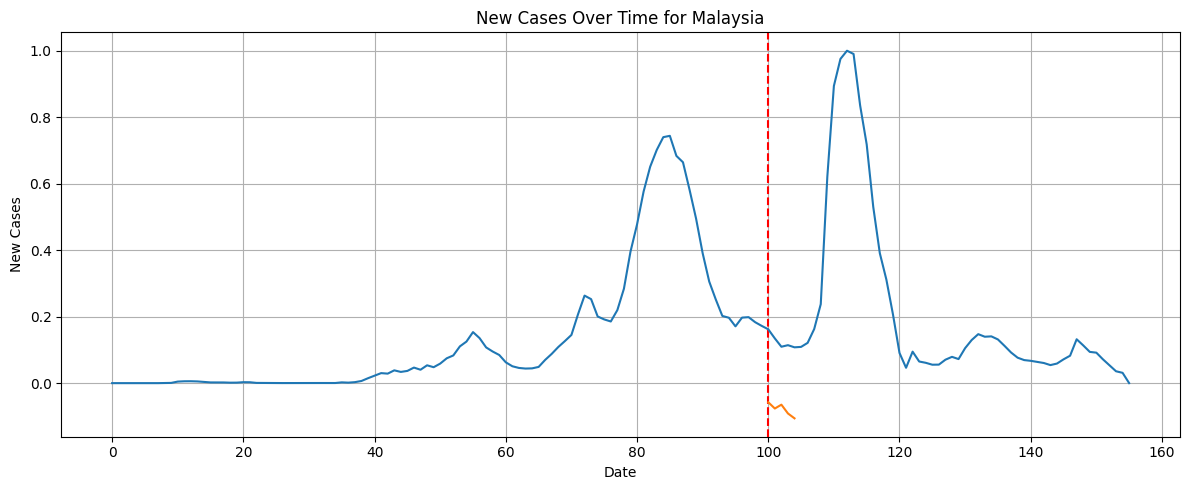

In [103]:
import matplotlib.pyplot as plt
length_data = len(simulate_data)
x_pred = np.arange(random_index, random_index + seq_length_out)
plt.figure(figsize=(12, 5))
plt.axvline(x=random_index, color='red', linestyle='--', label=f'Index {random_index}')
plt.plot(simulate_data.reset_index().index, scaler_y.fit_transform(simulate_data[['new_cases']].values))
plt.plot(x_pred, predicted_7_days, label='Prediction (next 5 days)')
plt.title(f"New Cases Over Time for {simulate_country}")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.grid(True)
plt.tight_layout()
plt.show()